### Dokument Summarization

### Quellen:

- Dipanjan S., "Text Analytics with python", 2016, Apress
- http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/


In [1]:
import nltk
sent_tokenizer = nltk.data.load("tokenizers/punkt/german.pickle")

In [2]:
import re, string
import pandas as pd
import spacy
#from spacy.lang.de import German
import numpy as np
from nltk.corpus import stopwords
from spacy.lemmatizer import Lemmatizer
import pandas as pd
#aus nltk
stopwords = stopwords.words("german")
stopwords.append("dass")

#Spacy-Modell
nlp = spacy.load('de_core_news_sm')
#https://github.com/explosion/spaCy/blob/master/spacy/lang/de/stop_words.py
from spacy.lang.de.stop_words import STOP_WORDS as spacy_stops
from string import punctuation

In [3]:
STOPWORDS = set(stopwords+list(spacy_stops)+list(punctuation))

## Text cleaning - Remove newlines, tabs, double spaces

In [4]:
def clean_text(text):
    cleaned_text = text.replace("\n", " ")
    cleaned_text= re.sub('\s+', ' ', cleaned_text)
    cleaned_text = re.sub(r'\s([,?.!"](?:\s|$))', r'\1',cleaned_text)
    return cleaned_text
    

## Parsing and cleaning sentences

In [5]:
def parse_sentences(document):
    REDAKTIONEN = ["( mit epd )", "( BM )", "( dpa )"]
    document = document.strip("+++")
    document = document.replace("+++", ".")
    document = document.replace("© Berliner Morgenpost 2018 –", "")
    document = document.replace("Alle Rechte vorbehalten.", "")
    for x in REDAKTIONEN:
        document = document.replace(x, "")
    #Parsing mit spacy
    doc = nlp(document)
    #Satzsegmentierung
    sentences = [sent.text for sent in doc.sents]
    for index, sent in enumerate(sentences):
        if len(sent.split())==1 and re.match("[-.,!?]", sent):
            sentences.remove(sent)
        if "0 0" in sent:
            sentences[index] = sent.strip("0 0")
        if ("© Berliner Morgenpost 2018".lower() in sent.lower()) or ("alle rechte vorbehalten" in sent.lower()):
            sentences.remove(sent)
    if len(sentences[0].split()) == 1:
        sentences.remove(sentences[0])
    return sentences

In [6]:
def parse_sentences_nltk(document):
    #hier normalize_for_py_library und wegnehmen in pagerank
    sentences = nltk.sent_tokenize(document,language='german')
    
    return sentences


In [7]:
def lemmatization(sent):
    doc = nlp(sent)
    #Ziehung der Lemmatas in einer Liste
    lemmatized_tokens = [token.lemma_ for token in doc]
    #Lemmatas werden wieder zu einem fließenden Satz
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [8]:
def lemmatize_tokens(sent):
    doc = nlp(sent)
    #Ziehung der Lemmatas in einer Liste
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_punct]
    return lemmatized_tokens 

In [9]:
def get_tokens_no_punct(sent):
    doc = nlp(sent)
    #tokens = [token.text for token in doc if (token.is_alpha or token.like_num)]
    tokens = [token.text for token in doc if not token.is_punct]
    tokens = [token for token in tokens]
    #tokenized_text = ' '.join(tokens)
    return tokens

In [10]:
def get_important_tokens(sent):
    valid_pos = ["PROPN", "VERB", "NOUN","ADJ"]
    doc = nlp(sent)
    tokens = [token.text for token in doc if (token.is_alpha and token.pos_ in valid_pos)]
    #tokenized_text = ' '.join(tokens)
    return tokens

In [11]:
def get_valid_chunks_text(sentences):
    all_chunks = []
    chunks=[]
    valid_chunks = []
    for sentence in sentences:
        doc = nlp(sentence)
        chunks = [chunk.text.lower() for chunk in doc.noun_chunks]
        valid_chunks.append(chunks)
    return valid_chunks
        

In [12]:
def get_chunks_in_sent(sent):
    doc = nlp(sent)
    return [chunk.text.lower() for chunk in doc.noun_chunks]

In [13]:
def remove_spec_chars(sent):
    #tokens = get_important_tokens(sent)
    tokens = get_tokens_no_punct(sent)
    #Entfernung aller speziellen Zeichen (punctuation)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens]) #filter object
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [14]:
def remove_stopwords(sent):
    #tokens = get_important_tokens(sent)
    tokens = get_tokens_no_punct(sent)
    filtered_tokens = [token for token in tokens if token.lower() not in (stopwords or spacy_stops)]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

### Normalize a corpus of sentences

In [15]:
def normalize_sents_corpus(corpus, std_lemmatize=True, tokenize=False):
    """Param corpus = normalized sentences """
    normalized_corpus = []
    for text in corpus:
        if std_lemmatize:
            text = lemmatization(text)
        else:
            text = text.lower()
        text = remove_spec_chars(text)
        text = remove_stopwords(text)
        #For Problem 2, hier immer false am besten
        if tokenize:
            text = get_tokens_no_punct(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)
    return normalized_corpus

In [16]:
def build_vocabulary(sents):
    vocabulary = set()
    for sent in sents:
        chunks = get_chunks_in_sent(sent)
        toks = get_important_tokens(sent)
        vocabulary.update(chunks)
        vocabulary.update(toks)
    vocabulary = list(vocabulary)
    for i in range(len(vocabulary)):
        splits =vocabulary[i].split()
        tokens = [token for token in splits if token and token not in STOPWORDS]
        vocabulary[i]= ' '.join(tokens)
    
    return list(set(filter(bool, vocabulary)))


## Pipeline for a single document

In [17]:
def normalize_for_py_library(text):
    cleaned_text = clean_text(text)
    sents = parse_sentences(cleaned_text)
    return ' '.join(sents)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [19]:
def build_feature_matrix(documents, feature_type="tfidf", vocabulary=[], stopwords=set(), n_range=(1,1)):  
    
    if feature_type == 'frequency':
        #bag of words model
        vectorizer = CountVectorizer(binary=True, min_df=3, max_df = 0.25, ngram_range=n_range, 
                                     tokenizer=get_tokens_no_punct, stop_words=STOPWORDS, vocabulary=vocabulary)
    elif feature_type == 'tfidf':
        #tfidf model
        vectorizer = TfidfVectorizer(ngram_range=n_range, 
                                     vocabulary=vocabulary, tokenizer=get_tokens_no_punct, min_df=3, 
                                    stop_words=STOPWORDS, sublinear_tf=True)
    elif feature_type == 'no_custom':
        
        vectorizer = TfidfVectorizer(analyzer="word", stop_words=STOPWORDS)
    else:
        raise Exception("Falsche Feature-Typ angegeben!")
        
    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    return vectorizer, feature_matrix

## NetworkX

In [20]:
import networkx
import matplotlib.pyplot as plt

In [21]:
%matplotlib inline

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
def pagerank_networkx_summarizer(original_docu,url = "", num_sentences=4,
                                 feature_type='tfidf', image=False, 
                                 sim_matr=False, ranking=False, dim=14, algo="standard", 
                                 alpha=0.85, std_lemma=True, 
                                 stopwords=STOPWORDS, n_range=(1,1), voc = True):
    #Das ist allererster aufruf auf ganzen Datensatz, s.u.
    #cleaned_text = normalize_for_py_library(original_docu) #VERWENDEN ABER AUßERHALB DER FUNKTION!!
    sentences = parse_sentences_nltk(original_docu)
    VOCAB = []
    if voc:  
        VOCAB = build_vocabulary(sentences)
    else:
        VOCAB = None #Vectorizers verwenden kein Voc
    
    actual_lentgh = len(sentences)

    
    #Small articles
    if actual_lentgh < num_sentences:
        print("Artikel zu kurz. URL = " + url)
        diff = num_sentences - actual_lentgh
        for i in range(diff):
            sentences.append(sentences[actual_lentgh-1]) #Satz einfach wiederholen
        
    norm_sentences = normalize_sents_corpus(sentences, std_lemmatize=std_lemma)
    
   
        
    vec, dt_matrix = build_feature_matrix(norm_sentences,
                                      feature_type=feature_type, vocabulary=VOCAB, n_range=n_range)
    similarity_matrix = (dt_matrix * dt_matrix.T)
        
    similarity_graph = networkx.from_scipy_sparse_matrix(similarity_matrix)
    if image:
        from networkx.drawing.nx_agraph import graphviz_layout
        #plt.figure(figsize=(dim,dim))
        #Plotting
        #standard
        #networkx.draw_networkx(similarity_graph)
        
        g = similarity_graph
    
        #Spring layout
        pos = networkx.spring_layout(g, iterations=20)
       # pos = graphviz_layout(g)
        plt.figure(figsize=(30, 30))
        networkx.draw(g, pos=pos, node_size=5500, node_color=range(len(norm_sentences)),
                      cmap=plt.cm.Wistia)
        networkx.draw_networkx_labels(g, pos=pos, font_size=50, font_weight='bold')
        plt.show()
        
    #PageRank Algorithmus von networkx
    scores = networkx.pagerank(similarity_graph, alpha=alpha)   
    
    ranked_sentences = sorted(((score, index) 
                                for index, score 
                                in scores.items()), 
                              reverse=True)
    
        
    top_sentence_indices = [ranked_sentences[index][1] 
                            for index in range(num_sentences)]
    top_sentence_indices.sort()
    #print("Top_sentence_indices: ")
    #print(top_sentence_indices)
    sents = []
    for index in top_sentence_indices:
        #print(sentences[index])
        sents.append(sentences[index])
    
    if sim_matr and ranking:
        return sents, np.round(similarity_matrix.todense(),3), ranked_sentences, VOCAB
    else:
        return sents, ranked_sentences

### Kurzes Beispiel networkx
https://taz.de/Fluechtlinge-auf-dem-Mittelmeer/!5517118/

In [24]:
ex_text = u"""ap/dpa | Ein Rettungsschiff mit mehr als 60 Flüchtlingen und Migranten an Bord darf nach einem Streit um Zuständigkeiten im spanischen Barcelona anlegen. Die „Open Arms“, ein Schiff der Hilfsgruppe Proactiva Open Arms aus Barcelona, werde aufgenommen, teilte die spanische Regierung am Samstag mit. Italien und Malta hatten eine Aufnahme zuvor verweigert – und sich dabei einen erbitterten Schlagabtausch geliefert.

Die „Open Arms“ hatte am Samstag angegeben, 60 Menschen im Mittelmeer nahe Libyen gerettet zu haben und bat darum, in Italien anlegen zu dürfen. Dies lehnte der italienische Innenminister Matteo Salvini ab und brachte Malta ins Spiel, dort sei der nächstgelegene Hafen. Malta wehrte sich aber gleich. Innenminister Michael Farrugia argumentierte, dass die winzige italienische Insel Lampedusa weniger weit vom Schiff entfernt liege. Die „Open Arms“ ist mittlerweile das dritte Rettungsschiff einer humanitären Gruppe mit Einsatz im Mittelmeer, das in den vergangenen drei Wochen einer ablehnende Haltung von Salvini gegenüberstand.

Das Schiff werde vermutlich vier Tage brauchen, um in Barcelona anzukommen, sagte der Kapitän des Begleitschiffs „Astral“. Unabhängig von der Rettungsaktion der „Open Arms“ las der spanische Seerettungsdienst am Samstag 63 Menschen auf. 58 Migranten seien in der Straße von Gibraltar in drei Booten gefunden worden, die in Nordafrika gestartet seien, hieß es. Fünf weitere seien weiter östlich nahe der Region Murcia gerettet worden.

Mehr Migranten und Flüchtlinge sind in diesem Jahr über die westliche Mittelmeerroute auf dem See- und Landweg nach Europa gekommen, als über die Route von Nordafrika nach Italien. Spaniens neue sozialistische Regierung unter Ministerpräsident Pedro Sánchez hat andere EU-Länder aufgefordert, gerettete Migranten mit Würde zu behandeln.

„Die Leute haben geschrien, ich hatte Angst“, sagte ein neun Jahre alter Junge aus der Zentralafrikanischen Republik an Bord der „Open Arms“. „Aber als ich das Rettungsboot gesehen habe, wusste ich, dass es keine Gefahr mehr gibt.“ Seine Mutter berichtete, seit Monaten in Libyen gelebt zu haben. Aus Angst vor einer etwaigen Entführung oder einem Verkauf als Sklavin habe sie ihre Unterkunft nie verlassen. „Zu Hause ist Krieg. Sie töten Menschen, sie schlagen Menschen, sie vergewaltigen Frauen, sie töten Jungen. Wir haben keinen Frieden.“

Italiens neue Regierung hatte zuletzt mehreren Schiffen von NGOs die Einfahrt in einen Hafen verwehrt: nämlich der „Aquarius“ von Ärzte ohne Grenzen und SOS Mediterranee und der „Lifeline“ von der deutschen Organisation Mission Lifeline. Beide Schiffe waren tagelang auf dem Meer blockiert. Die „Aquarius“ durfte nach einer Irrfahrt nach Spanien, die „Lifeline“ nach langem Ausharren nach Malta. Aber auch Malta verschärft die Gangart gegen Hilfsorganisationen und verweigerte bereits Schiffen die Einfahrt für einen Versorgungsstopp. Gegen den „Lifeline“-Kapitän wird ermittelt.
"""

In [25]:
cleaned_texxt = normalize_for_py_library(ex_text)

In [26]:
sents = parse_sentences_nltk(cleaned_texxt)

In [27]:
print("Sentences in the document:")
for i, sent in enumerate(sents):
    print("{}: {}".format(i, sent))

Sentences in the document:
0: | Ein Rettungsschiff mit mehr als 60 Flüchtlingen und Migranten an Bord darf nach einem Streit um Zuständigkeiten im spanischen Barcelona anlegen.
1: Die „Open Arms“, ein Schiff der Hilfsgruppe Proactiva Open Arms aus Barcelona, werde aufgenommen, teilte die spanische Regierung am Samstag mit.
2: Italien und Malta hatten eine Aufnahme zuvor verweigert – und sich dabei einen erbitterten Schlagabtausch geliefert.
3: Die „Open Arms“ hatte am Samstag angegeben, 60 Menschen im Mittelmeer nahe Libyen gerettet zu haben und bat darum, in Italien anlegen zu dürfen.
4: Dies lehnte der italienische Innenminister Matteo Salvini ab und brachte Malta ins Spiel, dort sei der nächstgelegene Hafen.
5: Malta wehrte sich aber gleich.
6: Innenminister Michael Farrugia argumentierte, dass die winzige italienische Insel Lampedusa weniger weit vom Schiff entfernt liege.
7: Die „Open Arms“ ist mittlerweile das dritte Rettungsschiff einer humanitären Gruppe mit Einsatz im Mittelme

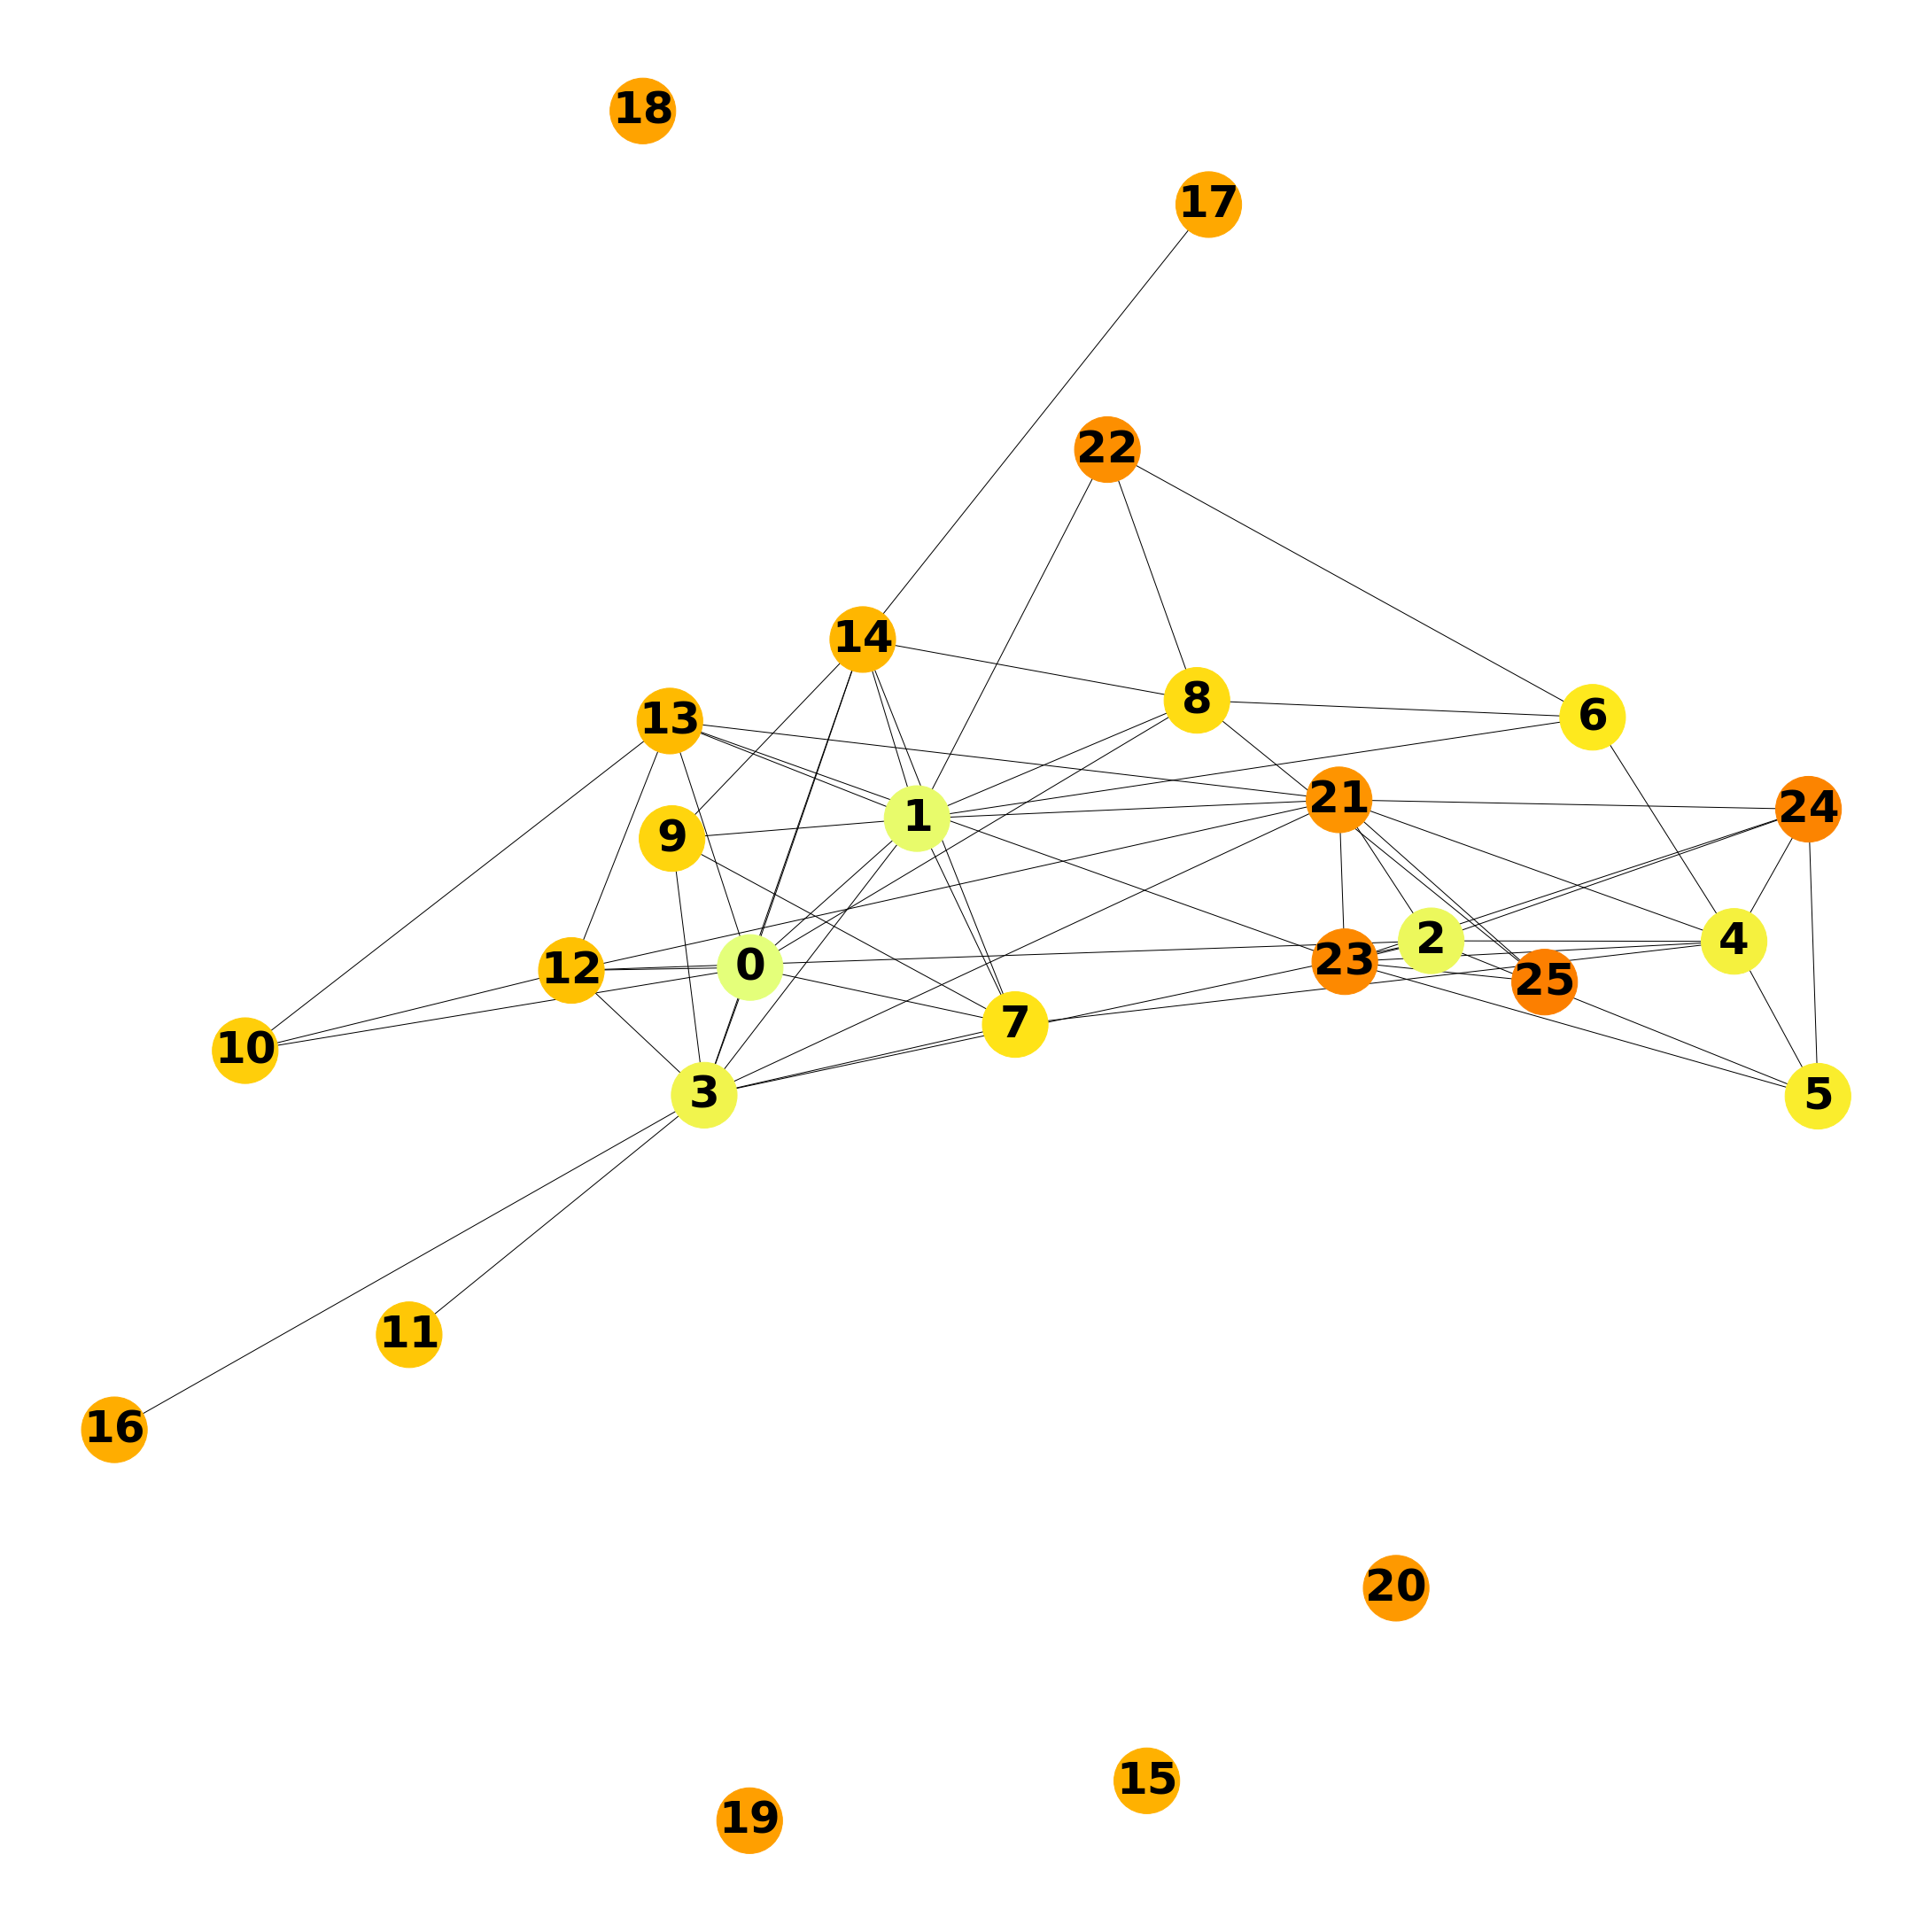

In [28]:
summarized_tfidf = pagerank_networkx_summarizer(cleaned_texxt,feature_type="no_custom", num_sentences=4,image=True, sim_matr=True, ranking=True, n_range=(1,1), voc=False)

In [29]:
for sent in summarized_tfidf[0]:
    print(sent, " ")

Die „Open Arms“, ein Schiff der Hilfsgruppe Proactiva Open Arms aus Barcelona, werde aufgenommen, teilte die spanische Regierung am Samstag mit.  
Die „Open Arms“ hatte am Samstag angegeben, 60 Menschen im Mittelmeer nahe Libyen gerettet zu haben und bat darum, in Italien anlegen zu dürfen.  
“ Italiens neue Regierung hatte zuletzt mehreren Schiffen von NGOs die Einfahrt in einen Hafen verwehrt: nämlich der „Aquarius“ von Ärzte ohne Grenzen und SOS Mediterranee und der „Lifeline“ von der deutschen Organisation Mission Lifeline.  
Die „Aquarius“ durfte nach einer Irrfahrt nach Spanien, die „Lifeline“ nach langem Ausharren nach Malta.  


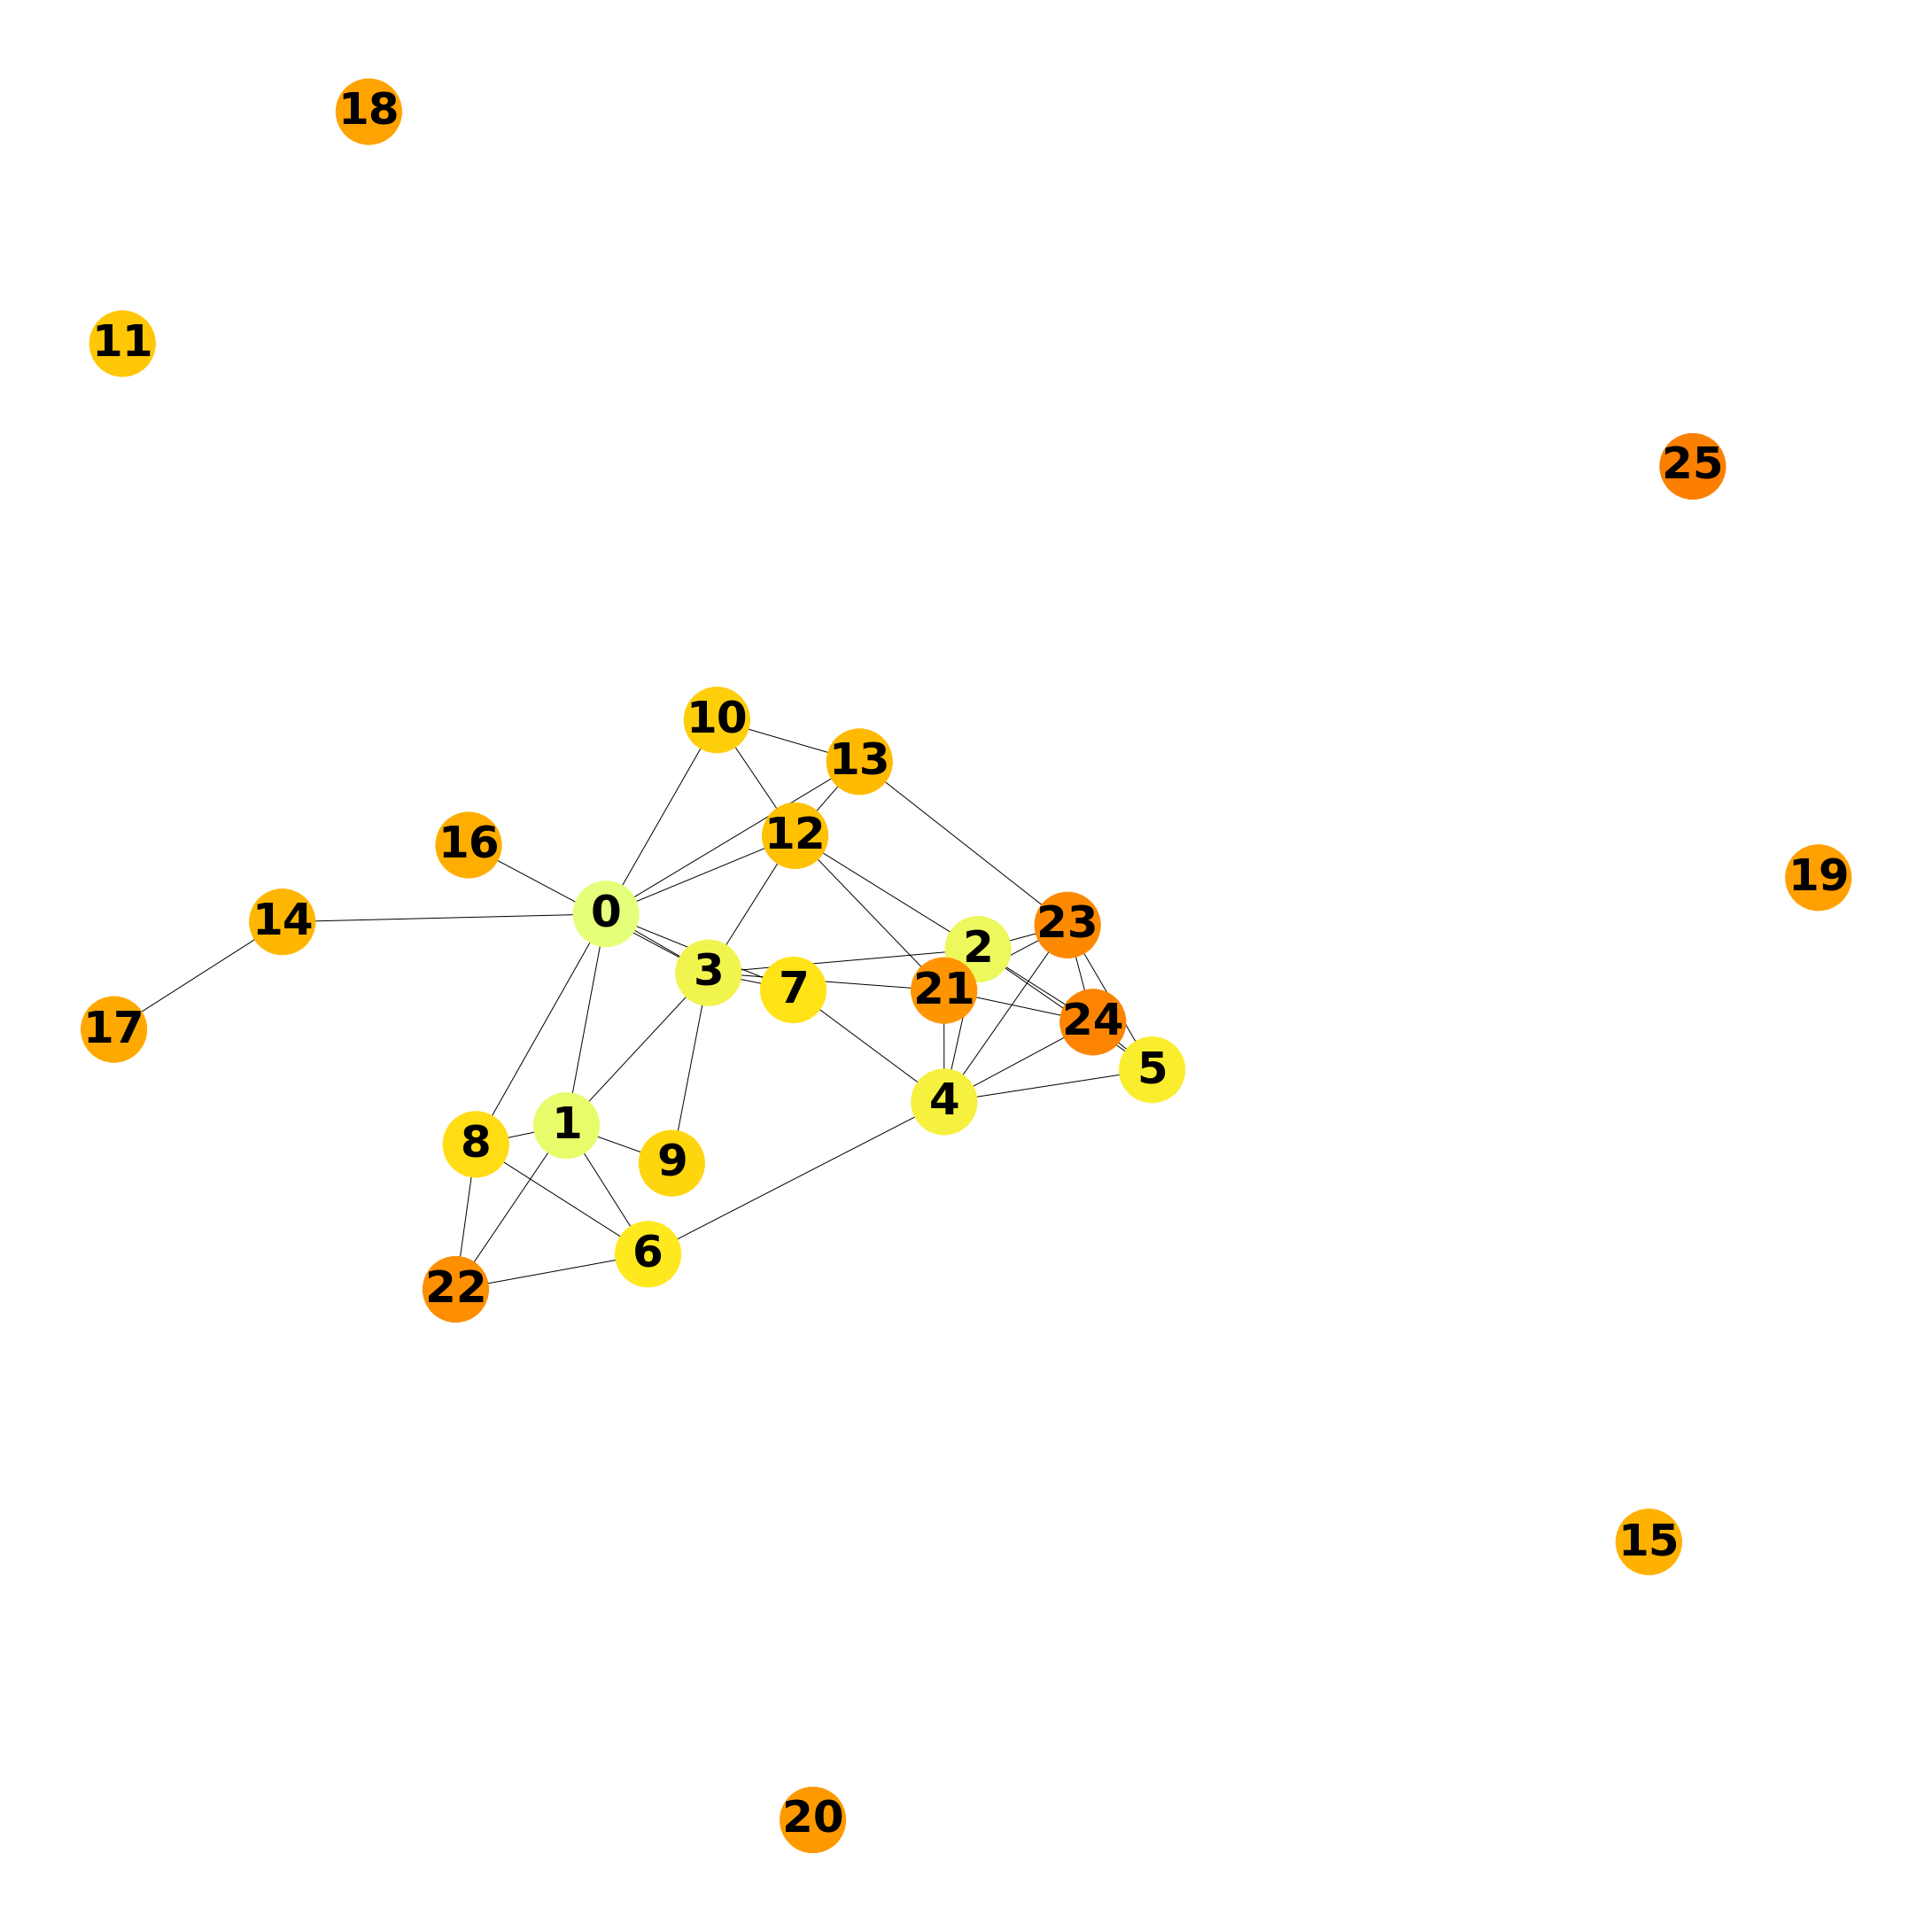

In [30]:
summarized_bow = pagerank_networkx_summarizer(cleaned_texxt, dim = 16, feature_type="frequency", num_sentences=4,image=True, sim_matr=True, ranking=True, n_range=(1,1))

In [31]:
for sent in summarized_bow[0]:
    print(sent, " ")

| Ein Rettungsschiff mit mehr als 60 Flüchtlingen und Migranten an Bord darf nach einem Streit um Zuständigkeiten im spanischen Barcelona anlegen.  
Die „Open Arms“, ein Schiff der Hilfsgruppe Proactiva Open Arms aus Barcelona, werde aufgenommen, teilte die spanische Regierung am Samstag mit.  
Die „Open Arms“ hatte am Samstag angegeben, 60 Menschen im Mittelmeer nahe Libyen gerettet zu haben und bat darum, in Italien anlegen zu dürfen.  
“ Italiens neue Regierung hatte zuletzt mehreren Schiffen von NGOs die Einfahrt in einen Hafen verwehrt: nämlich der „Aquarius“ von Ärzte ohne Grenzen und SOS Mediterranee und der „Lifeline“ von der deutschen Organisation Mission Lifeline.  


### Beispiel mit Uni- und Bigrammen

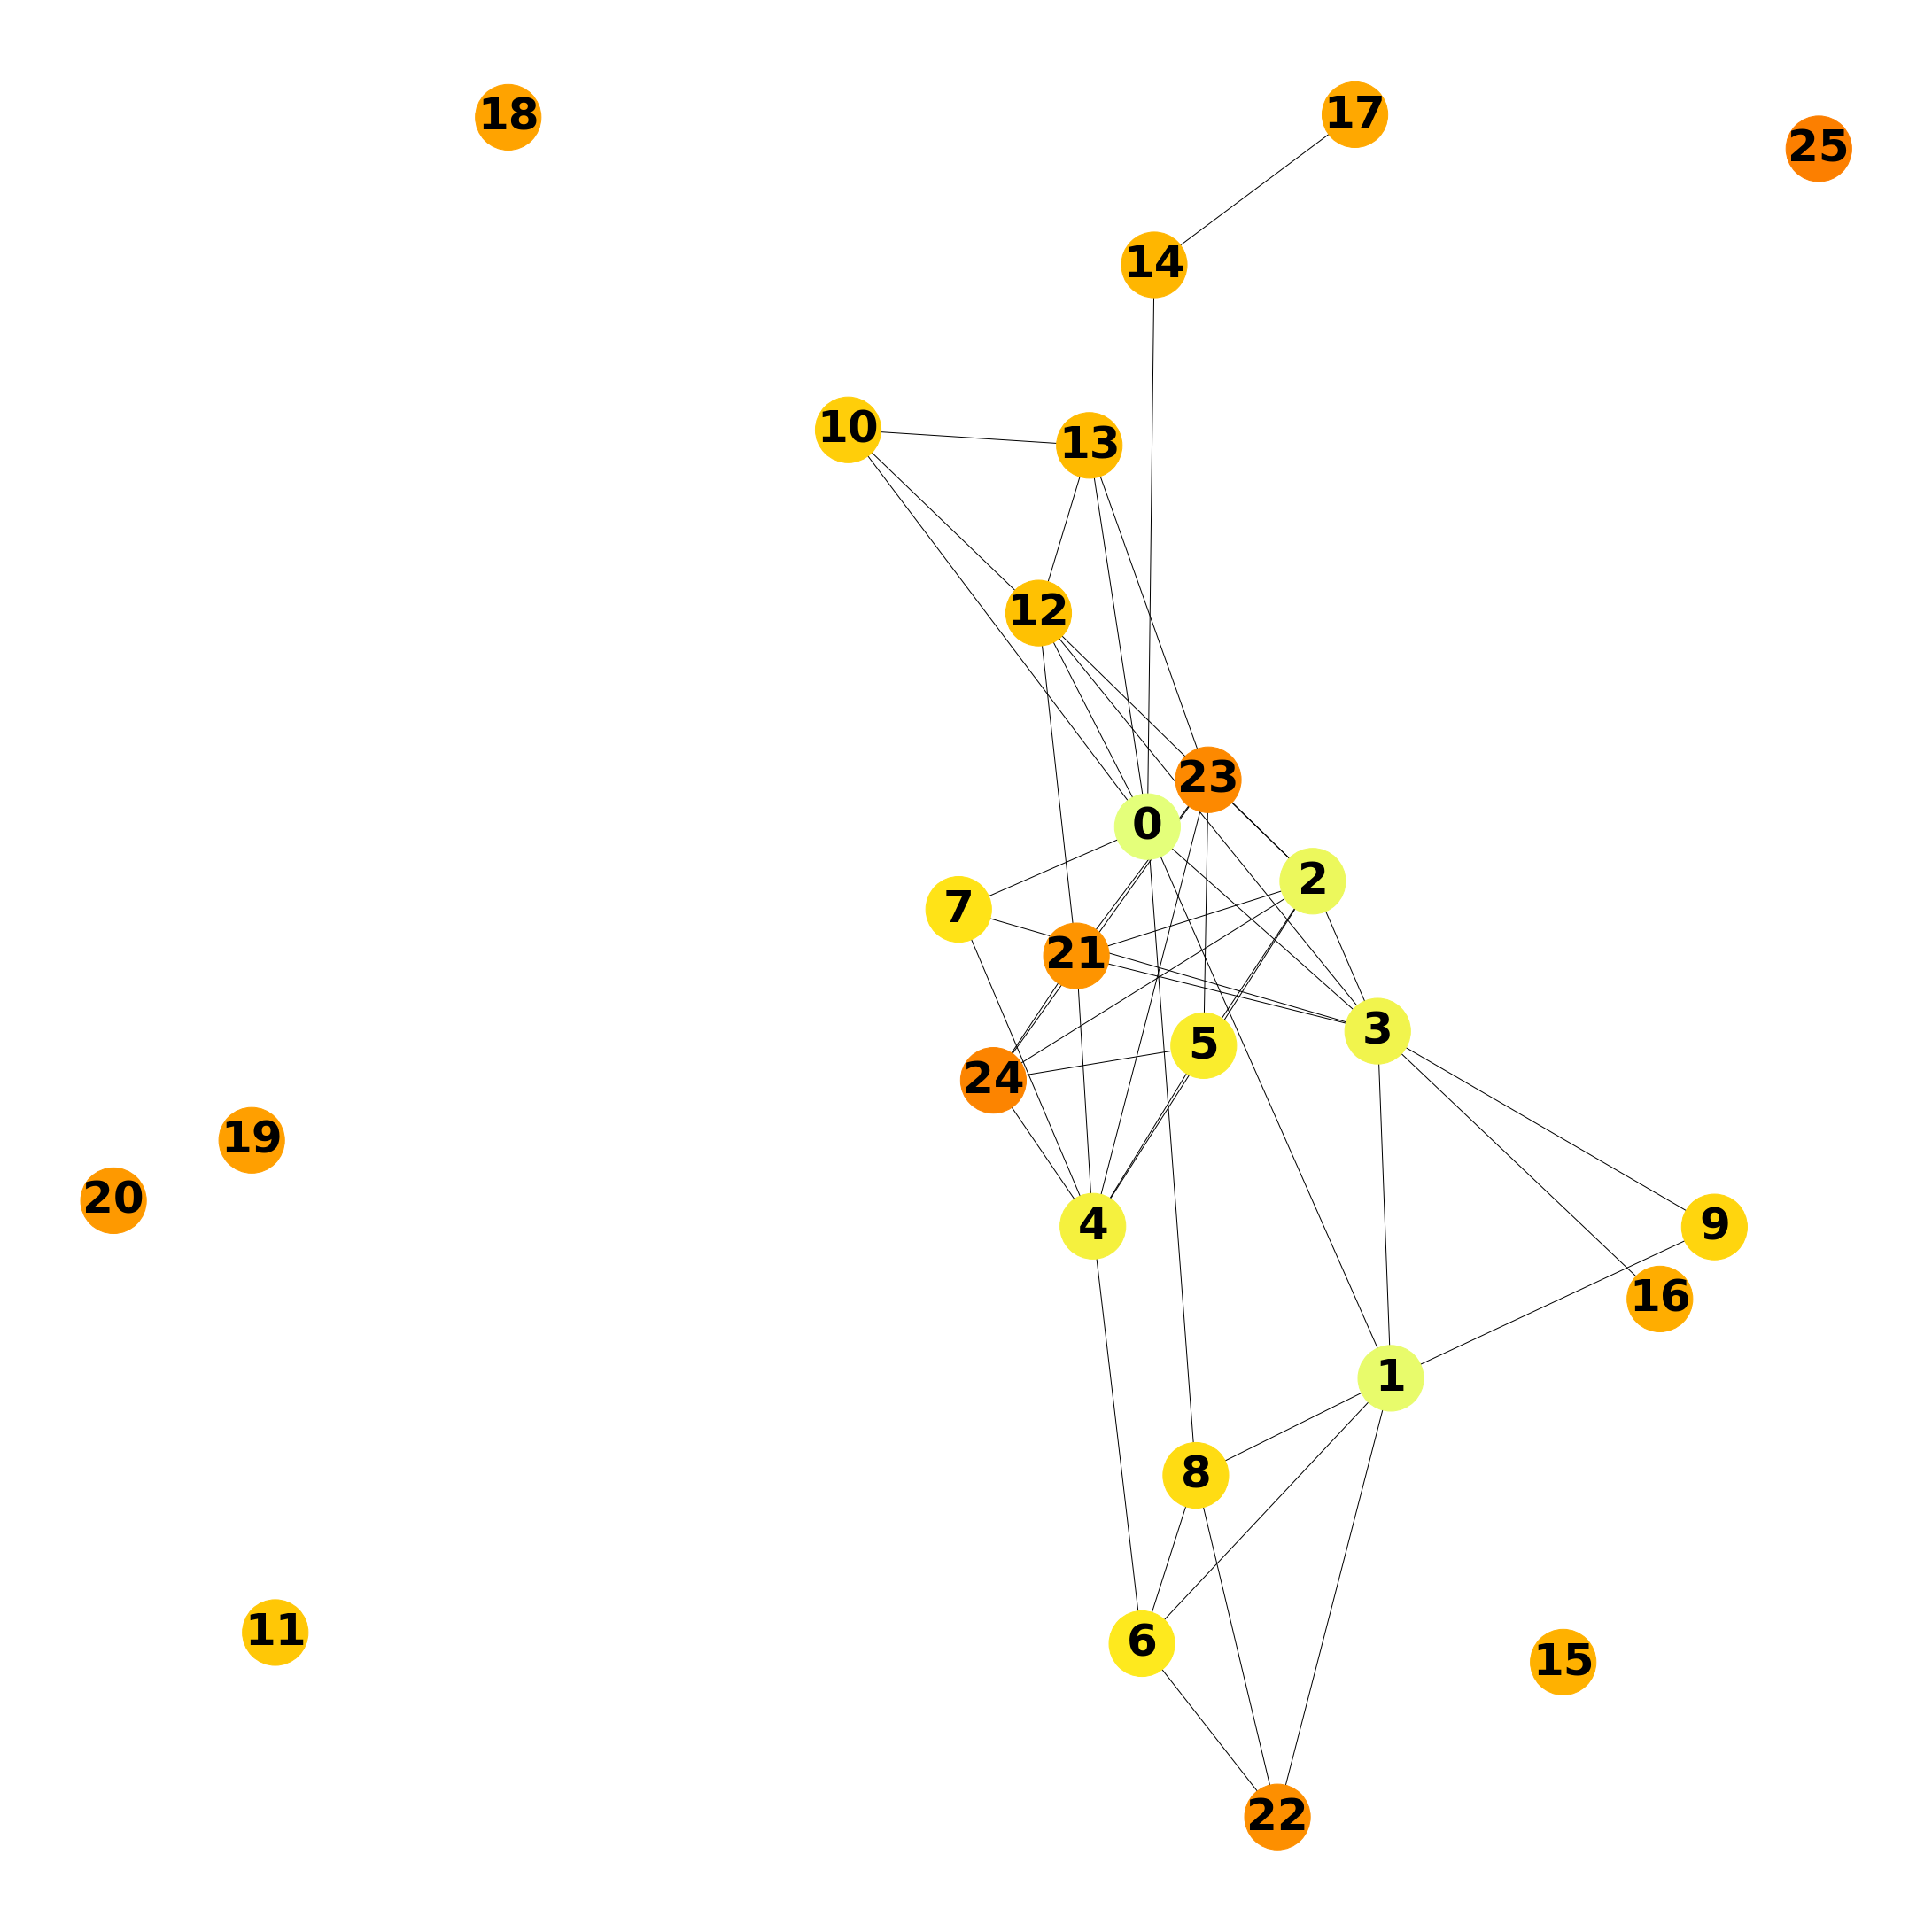

In [32]:
summarized_tfidf2 = pagerank_networkx_summarizer(cleaned_texxt, num_sentences=4,image=True, sim_matr=True, ranking=True, n_range=(1,2), voc=True)

In [33]:
summarized_tfidf2[0]

['| Ein Rettungsschiff mit mehr als 60 Flüchtlingen und Migranten an Bord darf nach einem Streit um Zuständigkeiten im spanischen Barcelona anlegen.',
 'Die „Open Arms“, ein Schiff der Hilfsgruppe Proactiva Open Arms aus Barcelona, werde aufgenommen, teilte die spanische Regierung am Samstag mit.',
 'Die „Open Arms“ hatte am Samstag angegeben, 60 Menschen im Mittelmeer nahe Libyen gerettet zu haben und bat darum, in Italien anlegen zu dürfen.',
 'Malta wehrte sich aber gleich.']

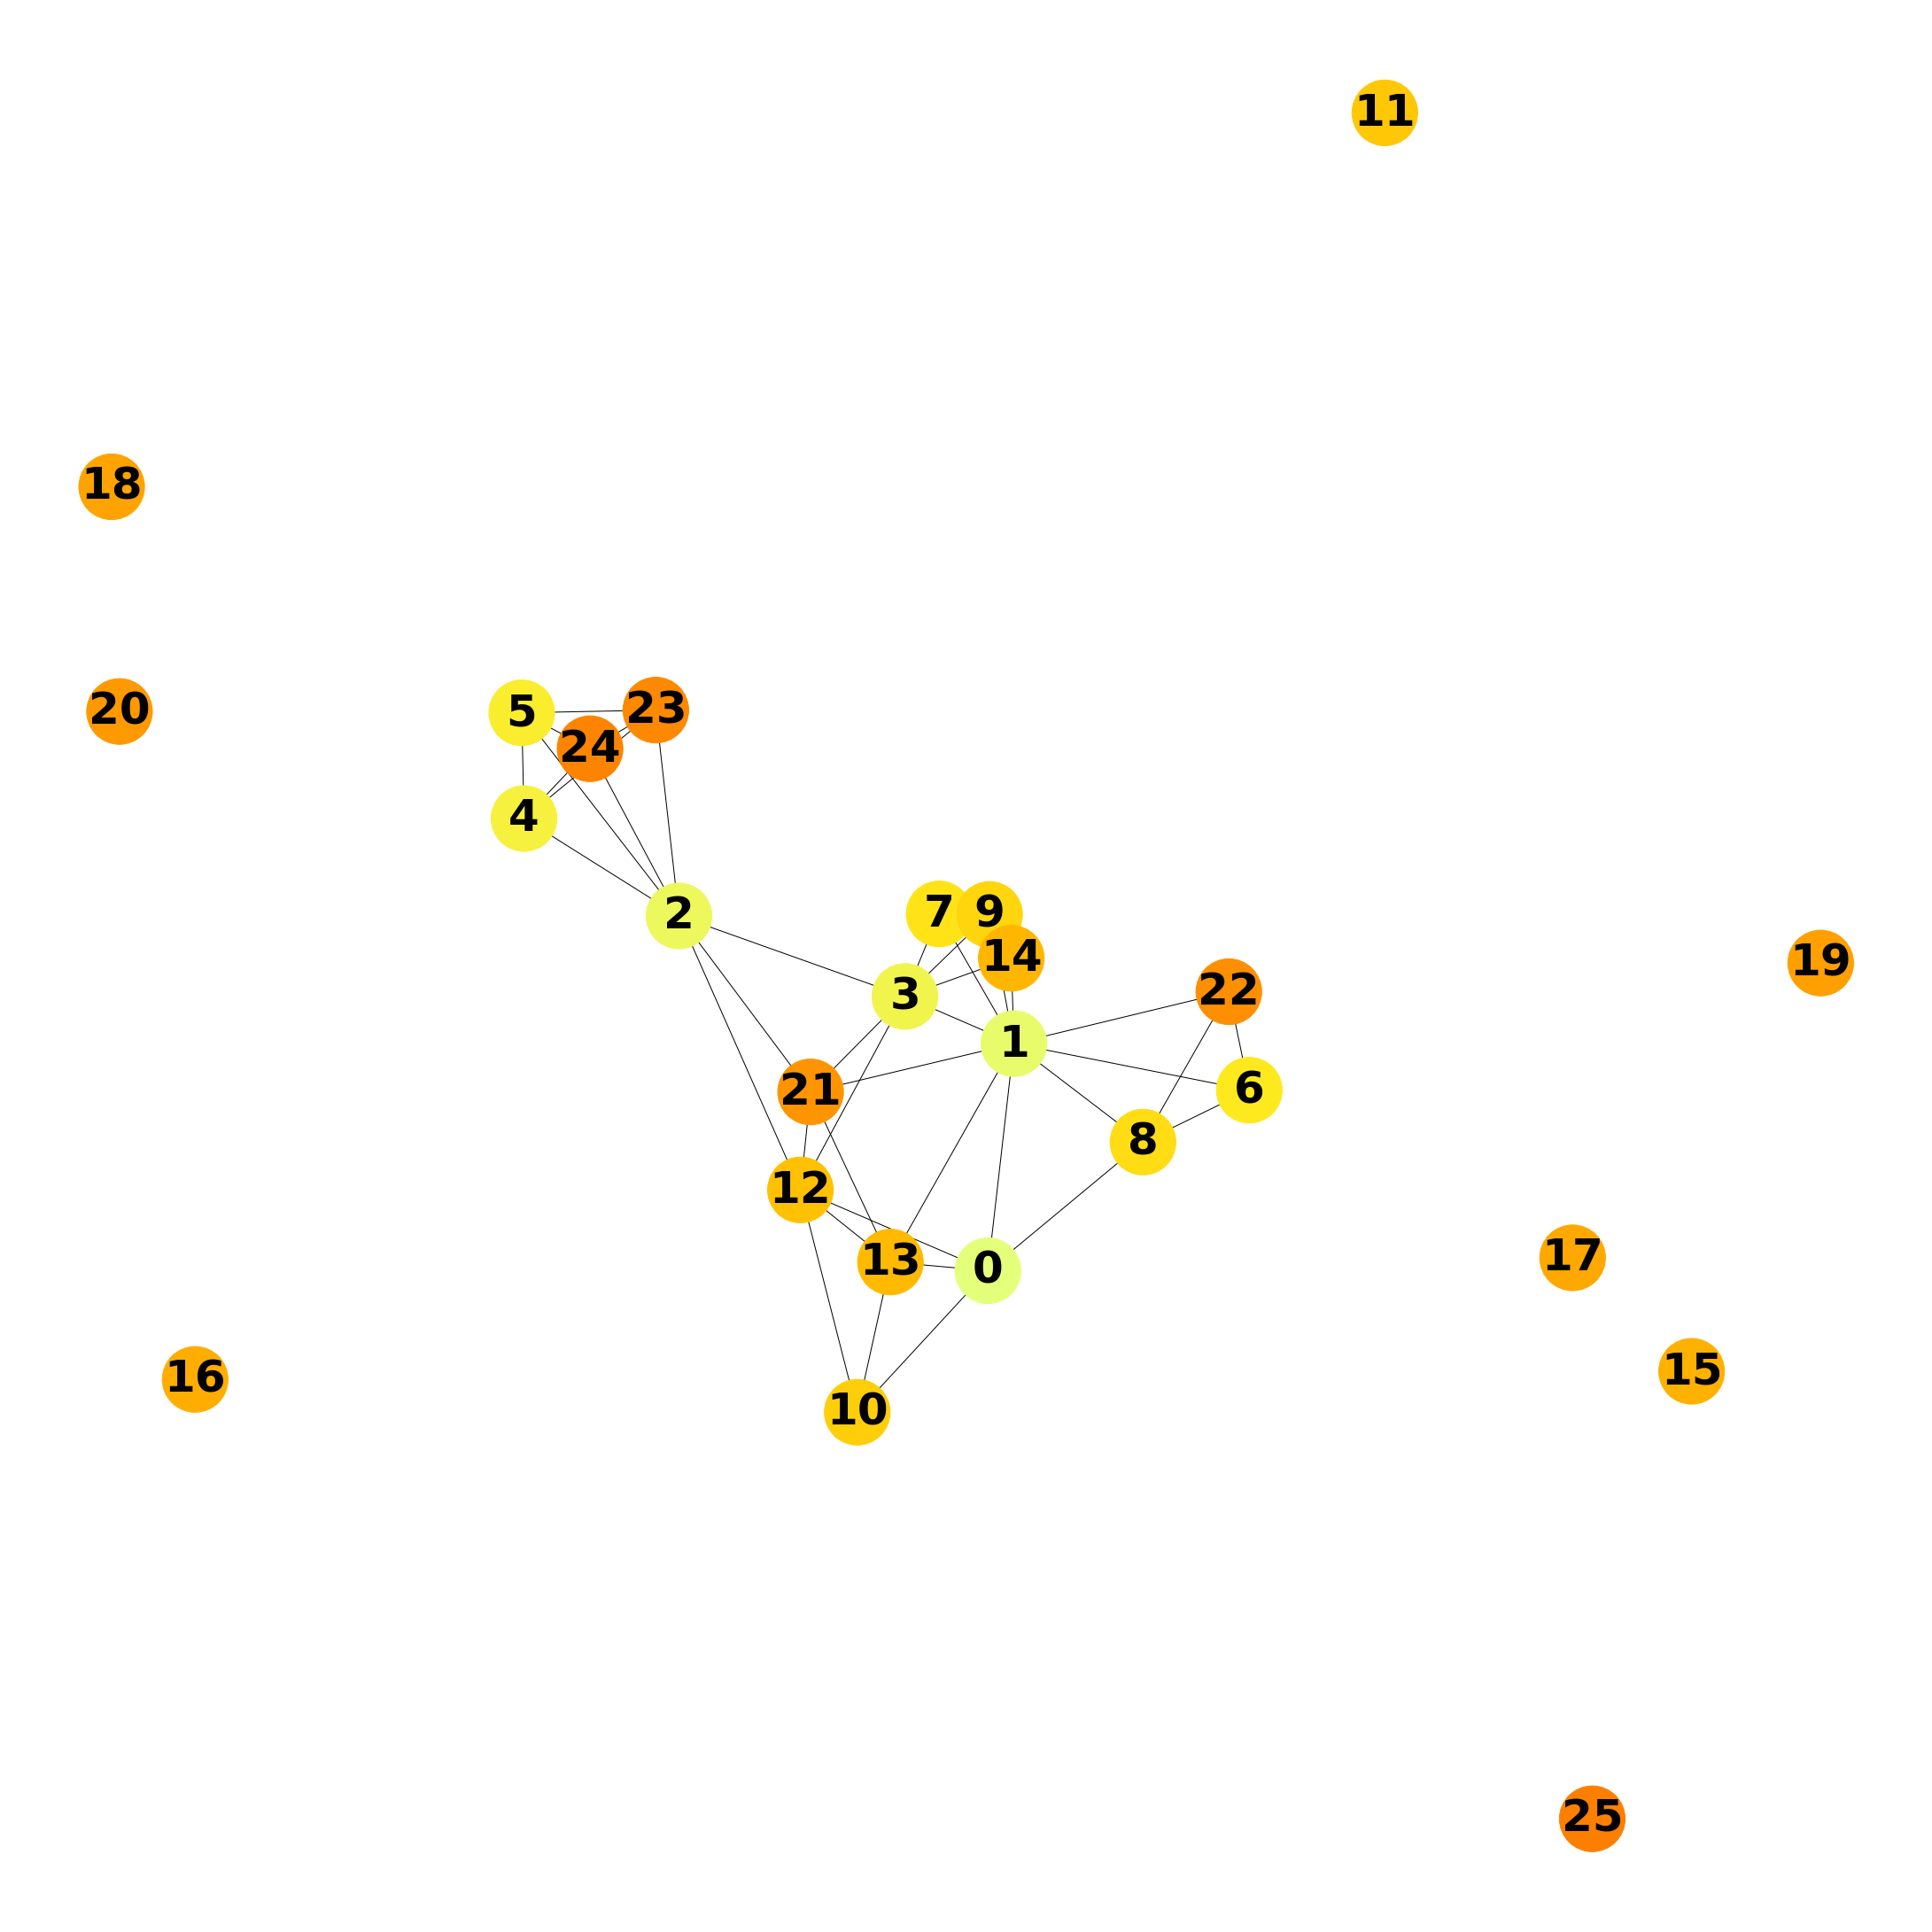

In [34]:
summarized_bow2 = pagerank_networkx_summarizer(cleaned_texxt,dim=18, feature_type="frequency", num_sentences=4,image=True, sim_matr=True, ranking=True, n_range=(1,2), voc=False)

In [35]:
summarized_bow2[0]

['Die „Open Arms“, ein Schiff der Hilfsgruppe Proactiva Open Arms aus Barcelona, werde aufgenommen, teilte die spanische Regierung am Samstag mit.',
 'Italien und Malta hatten eine Aufnahme zuvor verweigert – und sich dabei einen erbitterten Schlagabtausch geliefert.',
 'Die „Open Arms“ hatte am Samstag angegeben, 60 Menschen im Mittelmeer nahe Libyen gerettet zu haben und bat darum, in Italien anlegen zu dürfen.',
 'Unabhängig von der Rettungsaktion der „Open Arms“ las der spanische Seerettungsdienst am Samstag 63 Menschen auf.']

### Similarity Matrix

In [36]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

### Matrix TF-IDF

In [37]:
summarized_tfidf[1]

array([[1.   , 0.068, 0.   , 0.185, 0.   , 0.   , 0.   , 0.076, 0.082,
        0.   , 0.067, 0.   , 0.16 , 0.062, 0.09 , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.068, 1.   , 0.   , 0.259, 0.   , 0.   , 0.052, 0.158, 0.13 ,
        0.371, 0.   , 0.   , 0.   , 0.062, 0.189, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.045, 0.078, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.071, 0.063, 0.117, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.072, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.049, 0.   , 0.085, 0.186, 0.   ],
       [0.185, 0.259, 0.071, 1.   , 0.   , 0.   , 0.   , 0.161, 0.   ,
        0.199, 0.   , 0.247, 0.063, 0.   , 0.106, 0.   , 0.121, 0.   ,
        0.   , 0.   , 0.   , 0.043, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.063, 0.   , 1.   , 0.104, 0.168, 0.073, 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0

### Matrix Bow

In [38]:
summarized_bow[1]

array([[6., 1., 0., 2., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 4., 0., 1., 0., 0., 1., 0., 2., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 4., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 1., 0.],
       [2., 1., 1., 6., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 5., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1., 0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 0., 0., 0., 0., 

### Sentence Ranking

In [39]:
summarized_tfidf[2][:4]

[(0.05322140527550954, 3),
 (0.05097977071064705, 1),
 (0.04334791957316042, 23),
 (0.04148978152124118, 21)]

In [40]:
summarized_bow[2][:4]

[(0.06416461285443197, 3),
 (0.0635373942767706, 0),
 (0.057182685742373104, 21),
 (0.0532578135090497, 1)]

### Zusammenfassung

In [41]:
summarized_tfidf[0]

['Die „Open Arms“, ein Schiff der Hilfsgruppe Proactiva Open Arms aus Barcelona, werde aufgenommen, teilte die spanische Regierung am Samstag mit.',
 'Die „Open Arms“ hatte am Samstag angegeben, 60 Menschen im Mittelmeer nahe Libyen gerettet zu haben und bat darum, in Italien anlegen zu dürfen.',
 '“ Italiens neue Regierung hatte zuletzt mehreren Schiffen von NGOs die Einfahrt in einen Hafen verwehrt: nämlich der „Aquarius“ von Ärzte ohne Grenzen und SOS Mediterranee und der „Lifeline“ von der deutschen Organisation Mission Lifeline.',
 'Die „Aquarius“ durfte nach einer Irrfahrt nach Spanien, die „Lifeline“ nach langem Ausharren nach Malta.']

In [42]:
summarized_bow[0]

['| Ein Rettungsschiff mit mehr als 60 Flüchtlingen und Migranten an Bord darf nach einem Streit um Zuständigkeiten im spanischen Barcelona anlegen.',
 'Die „Open Arms“, ein Schiff der Hilfsgruppe Proactiva Open Arms aus Barcelona, werde aufgenommen, teilte die spanische Regierung am Samstag mit.',
 'Die „Open Arms“ hatte am Samstag angegeben, 60 Menschen im Mittelmeer nahe Libyen gerettet zu haben und bat darum, in Italien anlegen zu dürfen.',
 '“ Italiens neue Regierung hatte zuletzt mehreren Schiffen von NGOs die Einfahrt in einen Hafen verwehrt: nämlich der „Aquarius“ von Ärzte ohne Grenzen und SOS Mediterranee und der „Lifeline“ von der deutschen Organisation Mission Lifeline.']

In [43]:
def summarize_articles(df, feature_type="tfidf"):
    summaries = [[], [], [], [],[]]
    N = len(df)
    for i in range(N):
        summaries[0].append(df.loc[i,:][0]) #link
        text = df.loc[i,:][1]
        try:
            summary = pagerank_networkx_summarizer(text, url=df.loc[i,:][0], feature_type=feature_type, n_range=(1,1), num_sentences=4)
            summaries[1].append(summary[0][0])
            summaries[2].append(summary[0][1])
            summaries[3].append(summary[0][2])
            summaries[4].append(summary[0][3])
        except:
            
            print("Problem with artcile: ", df.loc[i,:][0], "Index: ", i)
        if i%100==0:
            print("Giro: ", i)
    return summaries

In [44]:
import pandas as pd

In [48]:
data = pd.read_csv("neue_stichprobe.csv", sep=",")

In [49]:
data.head()

,Unnamed: 0,url,text
0,0,http://www.taz.de/Wolfgang-Kubicki-vor-dem-FDP...,"taz: Herr Kubicki, die FDP denkt ergebnisoffe..."
1,1,http://www.taz.de/Kommentar-AfD-auf-dem-Kathol...,"Ja, es gibt Gründe, die dafür sprechen, mit de..."
2,2,http://www.taz.de/Kommentar-Kopftuchverbot-an-...,Und wieder ein Kopftuchurteil. Steigt noch jem...
3,3,http://www.taz.de/Konflikt-zwischen-Israel-und...,AVIV/JERUSALEM/BEIRUT/DAMASKUS dpa/rtr | Der K...
4,4,http://www.taz.de/Berliner-Gericht-zum-Kopftuc...,taz | Eine Berliner Lehrerin mit Kopftuch hat ...


In [50]:
article = data.text
article.head()

0     taz: Herr Kubicki, die FDP denkt ergebnisoffe...
1    Ja, es gibt Gründe, die dafür sprechen, mit de...
2    Und wieder ein Kopftuchurteil. Steigt noch jem...
3    AVIV/JERUSALEM/BEIRUT/DAMASKUS dpa/rtr | Der K...
4    taz | Eine Berliner Lehrerin mit Kopftuch hat ...
Name: text, dtype: object

In [52]:
data["cleaned"] = data.text.apply(parse_sentences_nltk)

In [54]:
data.cleaned[0]

[' taz: Herr Kubicki, die FDP denkt ergebnisoffen über eine Frauenquote nach.',
 'Angenommen, sie käme: Ist das dann noch Ihre Partei?',
 'Wolfgang Kubicki : Für mich ist die Quote nicht so wichtig, dass ich dadurch den Bezug zu meinen Freien Demokraten verlieren würde, denen ich seit bald 48 Jahren angehöre.',
 'Aber es wäre schon eine echte Herausforderung, nachdem wir uns jahrzehntelang gegen eine Frauenquote gewehrt haben.',
 'Wenn sie denn eingeführt würde.',
 'Sie haben im Spiegel gesagt: „Wir würden die Frauen doch mit Handkuss nehmen.',
 'Viele Frauen scheuen die Auseinandersetzung.',
 'Wenn Frauen in den Wettbewerb gehen, passiert das häufig untereinander.',
 '“ Das ist das Bedauerliche.',
 'Sie schieben den Schwarzen Peter den Frauen zu.',
 'Nein.',
 'Ich meine nur, dass sich in einem solchen Falle niemand darüber beklagen sollte, dass Frauen unterdurchschnittlich vertreten sind.',
 'Denn das könnten sie selbst ändern.',
 'Ich habe erlebt, dass Frauen im Zweifel stark genug s

In [ ]:
data["summarized_tf-idf"] = data.text.apply(pagerank_networkx_summarizer)

In [ ]:
data["summarized_tf-idf"].head()

## Similarity

Still needs some changes

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def compute_similarity(s1, s2):
    vectorizer1 = []
    vectorizer2 =[]
    token_vectorizer_df1 = CountVectorizer(tokenizer=get_tokens_no_punct, stop_words=STOPWORDS, ngram_range=(1,1))
    token_vectorizer_df2 = CountVectorizer(tokenizer=get_tokens_no_punct, stop_words=STOPWORDS, ngram_range=(1,1))
    for i in range(len(s1)):
        vectorizer1.append(token_vectorizer_df1.fit_transform(s1[i]).toarray())
        vectorizer2.append(token_vectorizer_df2.fit_transform(s2[i]).toarray())
        tfidfTran1 = TfidfTransformer(norm="l2")
        tfidfTran2 = TfidfTransformer(norm="l2")
        tfidfTran1.fit(vectorizer1)
        tfidfTran2.fit(vectorizer2)
        tfidf_matrix1 = tfidfTran1.transform(vectorizer1)
    return vectorizer1, vectorizer2

In [ ]:
v1,v2 = compute_similarity(summaries_, summaries)

In [ ]:
v1

## Weitere Summarization-Bibliotheken

In [ ]:
from gensim.summarization import summarize

In [ ]:
def gensim_summarizer(text):
    cleaned_text = normalize_for_py_library(text)
    summary = summarize(cleaned_text, split=True)
    return summary

In [ ]:
#summary = gensim_summarizer(feature_df.iloc[1912].text)
summary = gensim_summarizer(ex_text)
summary

### Extraction mit sumy

https://medium.com/@ondenyi.eric/extractive-text-summarization-techniques-with-sumy-3d3b127a0a32

In [ ]:
import sys

!{sys.executable} -m pip install sumy

In [ ]:
import sumy

In [ ]:
#Plain text parsers since we are parsing through text
from sumy.parsers.plaintext import PlaintextParser

#for tokenization
from sumy.nlp.tokenizers import Tokenizer

In [ ]:
#name of the plain-text file ~ bbc news dataset
file = "001.txt"
#parser = PlaintextParser.from_string(file, Tokenizer("german"))
parser = PlaintextParser.from_file(file, Tokenizer("german"))

In [ ]:
from sumy.summarizers.lex_rank import LexRankSummarizer 
summarizer = LexRankSummarizer()
#Summarize the document with 2 sentences
summary = summarizer(parser.document, 4) 
for sentence in summary:
    print(sentence)

In [ ]:
from sumy.summarizers.luhn import LuhnSummarizer
summarizer_1 = LuhnSummarizer()
summary_1 =summarizer_1(parser.document,4)
for sentence in summary_1:
    print(sentence)

In [ ]:
from sumy.summarizers.lsa import LsaSummarizer
summarizer_2 = LsaSummarizer()
summary_2 =summarizer_2(parser.document,4)
for sentence in summary_2:
    print(sentence)

In [ ]:
from sumy.summarizers.text_rank import TextRankSummarizer
summarizer_3 = TextRankSummarizer()
summary_3 =summarizer_3(parser.document,4)
for sentence in summary_3:
    print(sentence)